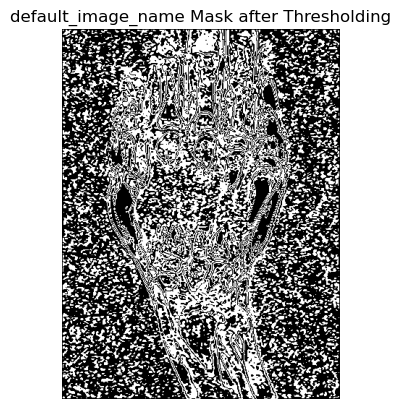

Batch image shape: torch.Size([1, 1, 6, 512, 384])
Batch label shape: torch.Size([1])


In [1]:
from pre_processing_py import HandScanDataset2, transform, validation_transform, train_df, valid_df, training_data_dir, display_images
from timm.models.layers import DropPath, trunc_normal_
import numpy as np

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, repeat
from torch.utils.data import DataLoader, Dataset
import numpy as np
from datetime import datetime

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
import numpy as np
import matplotlib.pyplot as plt

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads=4, mlp_ratio=4.0):
        super(TransformerBlock, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(embed_dim * mlp_ratio), embed_dim)
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = self.norm1(x + self.attn(x, x, x)[0])
        x = self.norm2(x + self.mlp(x))
        return x

import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, repeat
from torch.utils.data import DataLoader, Dataset
import numpy as np

class DisruptiveAutoencoder(nn.Module):
    def __init__(self, in_channels=1, embed_dim=64, depth=4, num_heads=4, mlp_ratio=4.0):
        super(DisruptiveAutoencoder, self).__init__()

        # Initial embedding layer to project input to the embedding dimension
        self.initial_embedding = nn.Conv3d(in_channels, embed_dim, kernel_size=1)

        # Encoder
        self.encoder_layers = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio) for _ in range(depth)
        ])

        # Decoder
        self.decoder_layers = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio) for _ in range(depth)
        ])
        
        # Reconstruction head to project back to original input dimensions
        self.reconstruction_head = nn.Conv3d(embed_dim, in_channels, kernel_size=1)

    def forward(self, x):
        original_shape = x.shape  # Save the original shape

        # Initial embedding
        x = self.initial_embedding(x)

        # Flatten spatial dimensions to create the sequence for the transformer
        x = rearrange(x, 'b c d h w -> b (d h w) c')  # (batch_size, sequence_length, embedding_dim)
        
        # Encoder
        for layer in self.encoder_layers:
            x = layer(x)
        
        # Decoder
        for layer in self.decoder_layers:
            x = layer(x)
        
        # Reshape back to the original 5D shape
        x = rearrange(x, 'b (d h w) c -> b c d h w', d=original_shape[2], h=original_shape[3], w=original_shape[4])

        # Reconstruction
        x = self.reconstruction_head(x)

        # Reshape back to original dimensions
        x = F.interpolate(x, size=original_shape[2:], mode='trilinear', align_corners=False)
        
        return x

    def add_noise(self, x, noise_level=0.0):
        noise = torch.randn_like(x) * noise_level
        return x + noise

    def local_mask(self, x, mask_ratio=0.1):
        b, c, d, h, w = x.shape
        num_masked = int(mask_ratio * c)
        mask_indices = torch.randperm(c)[:num_masked]
        x[:, mask_indices, :, :, :] = 0
        return x

    def compute_loss(self, reconstructed, original, zsim, zlabel, alpha=0.05):
        reconstructed = F.interpolate(reconstructed, size=original.shape[2:], mode='trilinear', align_corners=False)
        l1_loss = F.l1_loss(reconstructed, original)
        bce_loss = F.binary_cross_entropy_with_logits(zsim, zlabel)
        contrastive_loss = alpha * bce_loss
        total_loss = l1_loss + contrastive_loss
        return total_loss, l1_loss, contrastive_loss


In [5]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.activation_count = 0

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                self.activation_count += 1
                return True
        return False


In [6]:
results_path='/Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/Masters - 23-24/Project'

In [7]:
batch_size = 1
test_subjects_df = train_df.iloc[:3]
# Initialize dataset and data loader
train_dataset = HandScanDataset2(labels_df=test_subjects_df, data_dir=training_data_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [8]:
valid_subjects_df = valid_df.iloc[:3]
# Initialize the dataset with the selected subjects
valid_dataset = HandScanDataset2(labels_df=valid_subjects_df, data_dir=training_data_dir, transform=validation_transform)
# Create a data loader for testing
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, repeat
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

def visualize_images(original_images, masked_images, reconstructed_images, num_slices=1):
    """
    Visualizes original, masked, and reconstructed images for a few slices.

    Args:
        original_images (torch.Tensor): The original input images.
        masked_images (torch.Tensor): The images after local masking.
        reconstructed_images (torch.Tensor): The reconstructed images by the autoencoder.
        num_slices (int): Number of slices to visualize from the 3D images.
    """
    # Detach tensors and move to CPU before converting to numpy arrays
    original_images = original_images.detach().cpu().numpy()
    masked_images = masked_images.detach().cpu().numpy()
    reconstructed_images = reconstructed_images.detach().cpu().numpy()

    batch_size = original_images.shape[0]

    for i in range(min(batch_size, 2)):  # Visualize up to 2 subjects
        for slice_idx in range(num_slices):
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(original_images[i, 0, slice_idx, :, :], cmap='gray')
            plt.title(f'Original - Slice {slice_idx}')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(masked_images[i, 0, slice_idx, :, :], cmap='gray')
            plt.title(f'Masked - Slice {slice_idx}')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(reconstructed_images[i, 0, slice_idx, :, :], cmap='gray')
            plt.title(f'Reconstructed - Slice {slice_idx}')
            plt.axis('off')

            plt.show()


Epoch 1/10 [Training]:   0%|          | 0/3 [04:44<?, ?it/s, Total Loss=94.5723, L1 Loss=94.5723, Contrastive Loss=0.0000]

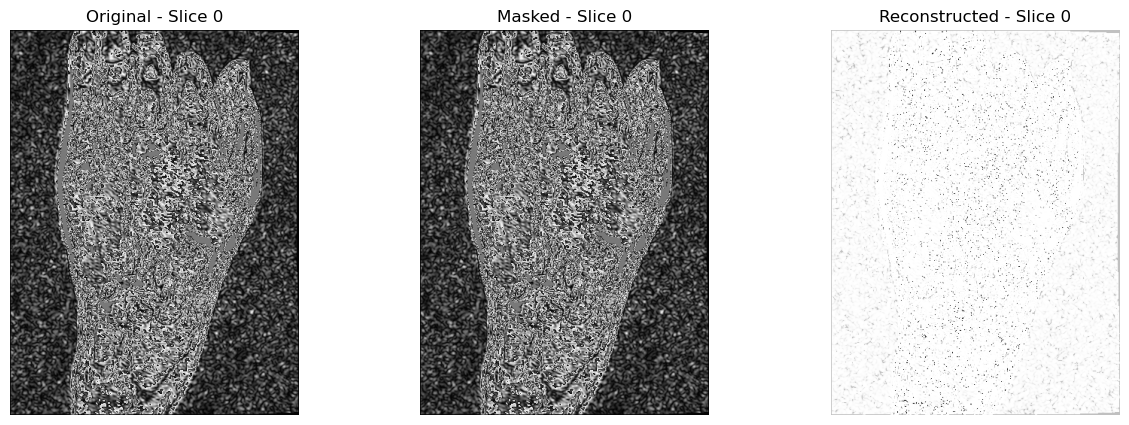

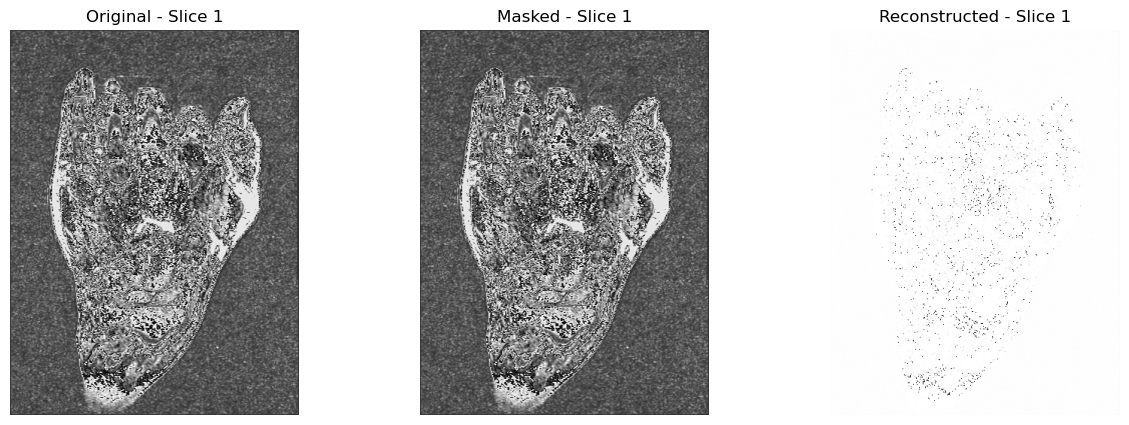

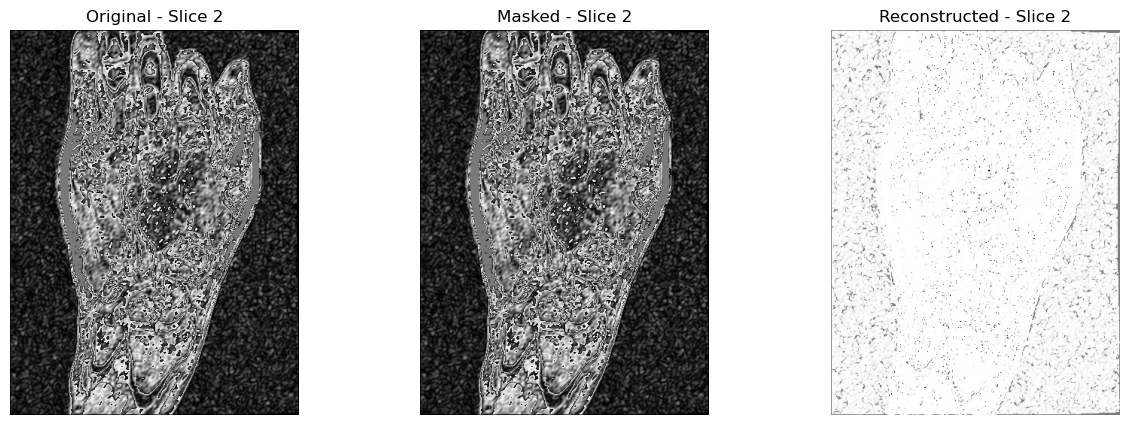

Epoch 1/10 [Training]:  33%|███▎      | 1/3 [04:45<09:31, 285.64s/it, Total Loss=94.5723, L1 Loss=94.5723, Contrastive Loss=0.0000]

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, repeat
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm import tqdm  # Progress bar library
import matplotlib.pyplot as plt  # For visualizing images

# Assuming DisruptiveAutoencoder model has been defined correctly without patch embedding.
dae_model = DisruptiveAutoencoder(
    in_channels=1,       # Input channel dimension, typically 1 for grayscale medical images
    embed_dim=64,        # Embedding dimension size
    depth=4,             # Number of transformer layers
    num_heads=4,         # Number of attention heads
    mlp_ratio=4.0        # Ratio of MLP hidden layer dimension to embedding dimension
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dae_model = dae_model.to(device)

# Optimizer and loss function
optimizer = torch.optim.Adam(dae_model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 10

# Define the EarlyStopper
early_stopper = EarlyStopper(patience=3, min_delta=0.001)

# Training loop
for epoch in range(num_epochs):
    dae_model.train()  # Set model to training mode
    epoch_loss = 0

    # Progress bar for training
    train_pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs} [Training]")

    for batch_idx, (images, labels) in train_pbar:
        images = images.to(device)  # Move images to the same device as the model
        labels = labels.to(device)  # Move labels to the same device as the model

        optimizer.zero_grad()

        # Apply noise and local masking directly to input images
        # noisy_images = dae_model.add_noise(images)
        masked_images = dae_model.local_mask(images)

        # Forward pass
        reconstructed_images = dae_model(masked_images)

        # Generate zsim and zlabel for contrastive learning (if used)
        zsim = torch.mm(reconstructed_images.view(reconstructed_images.size(0), -1), 
                        reconstructed_images.view(reconstructed_images.size(0), -1).T)
        zlabel = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()  # Binary label matrix for positive pairs

        # Compute combined loss
        total_loss, l1_loss, contrastive_loss = dae_model.compute_loss(reconstructed_images, images, zsim, zlabel)
        epoch_loss += total_loss.item()

        # Backpropagation
        total_loss.backward()
        optimizer.step()

        # Update progress bar description
        train_pbar.set_postfix({
            'Total Loss': f'{total_loss.item():.4f}',
            'L1 Loss': f'{l1_loss.item():.4f}',
            'Contrastive Loss': f'{contrastive_loss.item():.4f}'
        })

        # Visualize a few images and their reconstructions every 10 batches
        if batch_idx % 10 == 0:
            visualize_images(images, masked_images, reconstructed_images, num_slices=3)

    # Validation phase (or calculate validation loss)
    dae_model.eval()  # Set model to evaluation mode
    validation_loss = 0
    with torch.no_grad():
        valid_pbar = tqdm(enumerate(valid_loader), total=len(valid_loader), desc=f"Epoch {epoch + 1}/{num_epochs} [Validation]")
        
        for batch_idx, (images, labels) in valid_pbar:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            # noisy_images = dae_model.add_noise(images)
            masked_images = dae_model.local_mask(images)
            reconstructed_images = dae_model(masked_images)

            # Compute loss
            zsim = torch.mm(reconstructed_images.view(reconstructed_images.size(0), -1), 
                            reconstructed_images.view(reconstructed_images.size(0), -1).T)
            zlabel = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()

            _, l1_loss, contrastive_loss = dae_model.compute_loss(reconstructed_images, images, zsim, zlabel)
            validation_loss += l1_loss.item()

            # Visualize a few images and their reconstructions every 10 batches
            if batch_idx % 10 == 0:
                visualize_images(images, masked_images, reconstructed_images, num_slices=3)

    # Average validation loss
    validation_loss /= len(valid_loader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {validation_loss:.4f}')

    # Check early stopping
    if early_stopper.early_stop(validation_loss):
        # Save model parameters if early stopping criteria are met for the first time
        if early_stopper.activation_count == 1:
            # Generate a timestamp at the moment early stopping is triggered
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            print(f"\nEarly stopping criteria reached!\nSaving model parameters to {results_path}/{timestamp}_optimal_model_weights_epoch_{epoch + 1}.pth\n")
            # Save network parameters and losses
            opt_MLP_filepath = f"{results_path}/{timestamp}_optimal_model_weights_epoch_{epoch + 1}.pth"
            Early_Stop_Epoch = epoch + 1
            torch.save(dae_model.state_dict(), opt_MLP_filepath)

    # Continue training even after early stopping is triggered
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}, '
          f'L1 Loss: {l1_loss.item():.4f}, Contrastive Loss: {contrastive_loss.item():.4f}')
